In [1]:
import numpy as np
import pandas as pd

In [94]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
import xgboost as xgb

In [152]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [153]:
# dataset size
df.shape

(10000, 14)

In [154]:
# missing values?
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [155]:
#understanding columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [156]:
churn = df.copy()
churn = churn.drop(columns =['RowNumber','CustomerId','Surname'])
churned =churn.copy()

In [157]:
## change scientific format display
pd.options.display.float_format ="{:.2f}".format

In [158]:
churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


### analysis: estimated salary min 12 , check the outlier

In [159]:
churn[churn['EstimatedSalary'] <13]
#use > or <

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1


In [160]:
churn.describe(include='O')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [161]:
churn.shape

(10000, 11)

# 1. Data Cleaning


In [162]:
### change the binary encoded values to "yes" or "No"
churn['HasCrCard'] = churn['HasCrCard'].replace({1:"Yes",0:"No"})
churn['IsActiveMember'] = churn['IsActiveMember'].replace({1:"Yes",0:"No"})
churn['Exited'] = churn['Exited'].replace({1:"Yes",0:"No"})

In [163]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes
1,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No
2,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes
3,699,France,Female,39,1,0.00,2,No,No,93826.63,No
4,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No


In [164]:
# Feature Engineering
#1. Tenure
def tenure_group(x):
    if x<=2:
        return "Very New (0-2)"
    elif x>=3 and x<=5:
        return "Known (3-5)"
    elif x>=6 and x<=8:
        return "Long-Term (6-8)"
    elif x>=9:
        return "Loyal(>9)"
    

In [165]:
churn['Tenure_group'] = churn['Tenure'].apply(tenure_group)

In [166]:
churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_group
0,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes,Very New (0-2)
1,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No,Very New (0-2)
2,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes,Long-Term (6-8)
3,699,France,Female,39,1,0.00,2,No,No,93826.63,No,Very New (0-2)
4,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No,Very New (0-2)
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,Yes,No,96270.64,No,Known (3-5)
9996,516,France,Male,35,10,57369.61,1,Yes,Yes,101699.77,No,Loyal(>9)
9997,709,France,Female,36,7,0.00,1,No,Yes,42085.58,Yes,Long-Term (6-8)
9998,772,Germany,Male,42,3,75075.31,2,Yes,No,92888.52,Yes,Known (3-5)


In [167]:
#2. age
labels =['Young Adults (18-36)', 'Middle Aged (37-54)', 'Senior Citizens (55-73)', 'Retired (74-92)']
pd.cut(churn['Age'], bins =4, labels =labels).value_counts()

Age
Young Adults (18-36)       4609
Middle Aged (37-54)        4591
Senior Citizens (55-73)     728
Retired (74-92)              72
Name: count, dtype: int64

In [168]:
churn['Age_Group'] = pd.cut(churn['Age'], bins =4, labels=labels)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_group,Age_Group
0,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes,Very New (0-2),Middle Aged (37-54)
1,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No,Very New (0-2),Middle Aged (37-54)
2,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes,Long-Term (6-8),Middle Aged (37-54)
3,699,France,Female,39,1,0.00,2,No,No,93826.63,No,Very New (0-2),Middle Aged (37-54)
4,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No,Very New (0-2),Middle Aged (37-54)


In [220]:
labels =['Bad(350-449)','Poor(450-549)','Moderate(550-649)','Good(650-749)','Excellent(750-850)']
bins = [350, 450, 550, 650, 750, 850] 
pd.cut(churn['CreditScore'], bins =bins , labels =labels).value_counts()

CreditScore
Good(650-749)         3465
Moderate(550-649)     3316
Excellent(750-850)    1598
Poor(450-549)         1432
Bad(350-449)           184
Name: count, dtype: int64

In [222]:
churn['cr_score_gp'] = pd.cut(churn['CreditScore'], bins =bins , labels =labels)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_group,Age_Group,cr_score_gp
0,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes,Very New (0-2),Middle Aged (37-54),Moderate(550-649)
1,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,No,Very New (0-2),Middle Aged (37-54),Moderate(550-649)
2,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes,Long-Term (6-8),Middle Aged (37-54),Poor(450-549)
3,699,France,Female,39,1,0.00,2,No,No,93826.63,No,Very New (0-2),Middle Aged (37-54),Good(650-749)
4,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,No,Very New (0-2),Middle Aged (37-54),Excellent(750-850)


In [223]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  object  
 2   Gender           10000 non-null  object  
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  object  
 8   IsActiveMember   10000 non-null  object  
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  object  
 11  Tenure_group     10000 non-null  object  
 12  Age_Group        10000 non-null  category
 13  cr_score_gp      9995 non-null   category
dtypes: category(2), float64(2), int64(4), object(6)
memory usage: 957.6+ KB


In [224]:
churn['Exited'].dtype

dtype('O')

# 2.Univarient Analysis

In [225]:
sns.set_theme(style="darkgrid", palette="deep")

In [238]:
numerical= []
category = []
for i in churn.columns:
    if i=='Age_Group' or i=='cr_score_gp':
        category.append(i)
    elif (churn[i].dtype !='O'):
        numerical.append(i)
    else:
        category.append(i)

In [239]:
print(numerical)
print(category)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited', 'Tenure_group', 'Age_Group', 'cr_score_gp']


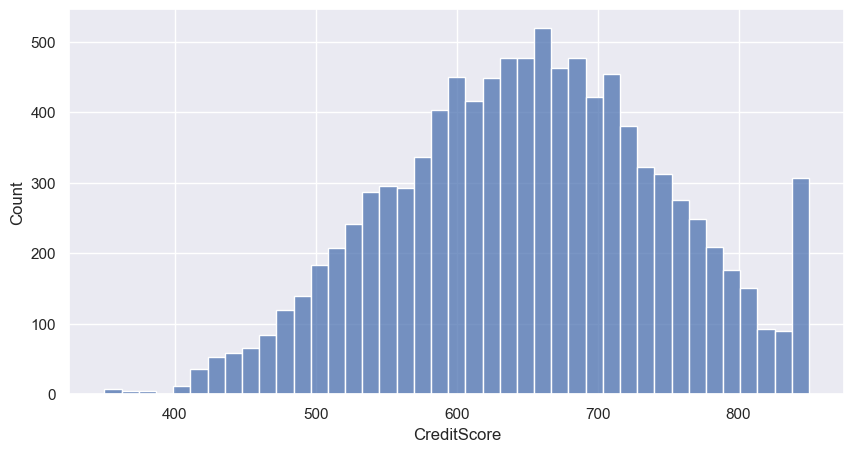

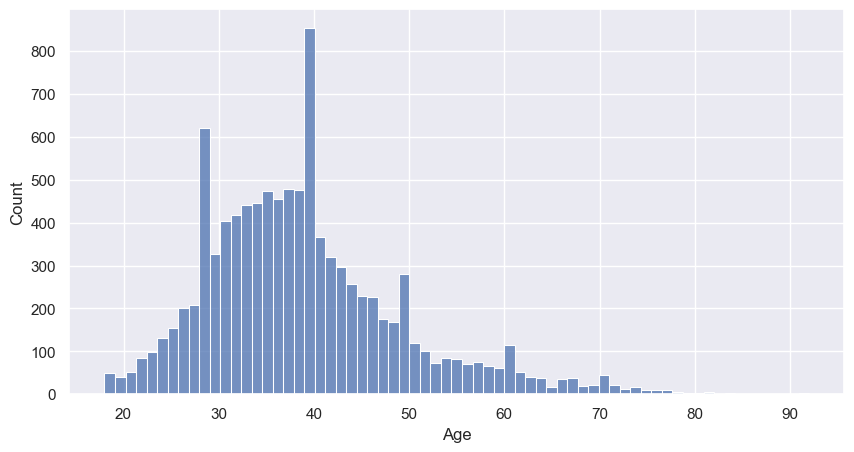

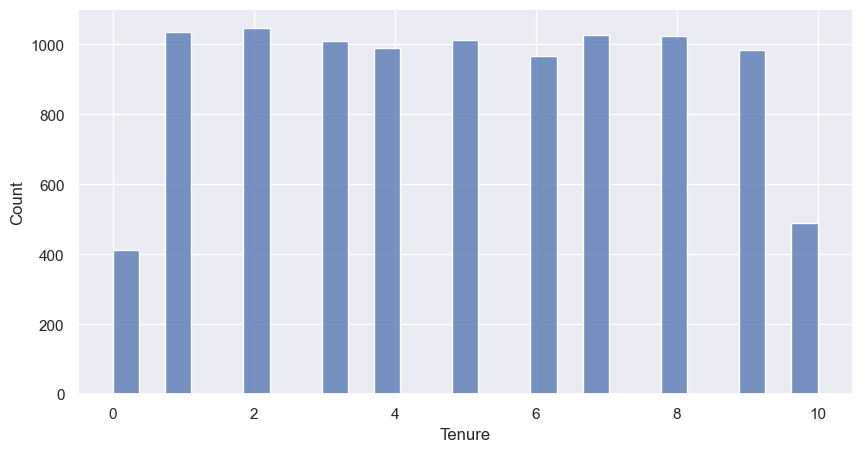

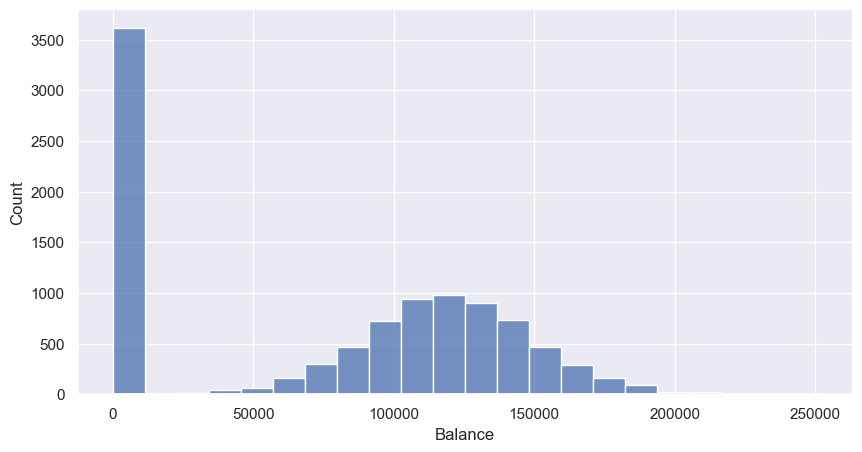

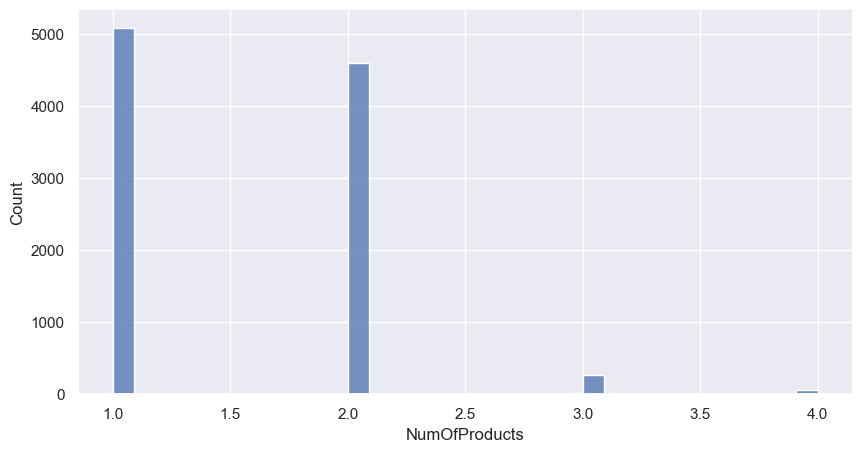

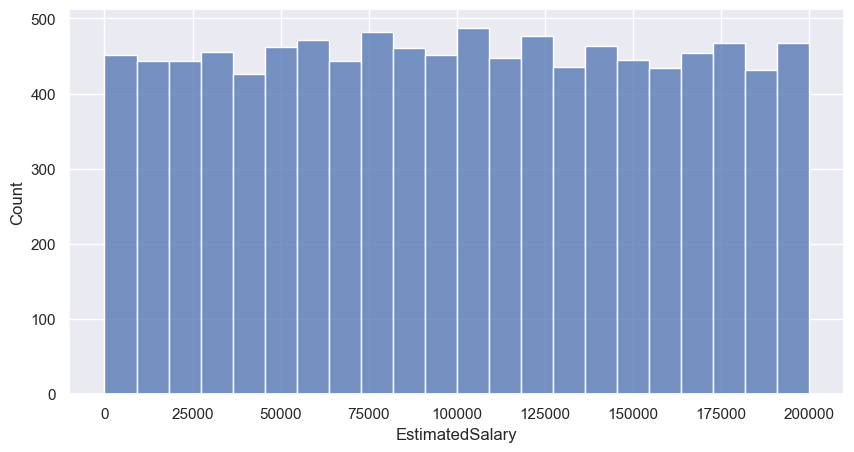

In [240]:

for i in numerical:
    plt.figure(figsize=(10,5))
    sns.histplot(churn[i])
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.show()

## Analysis

1. Estimated Salary looks very uniform, Meaning there are customers with very low salary estimation (expected a normal or right skewed histogram)

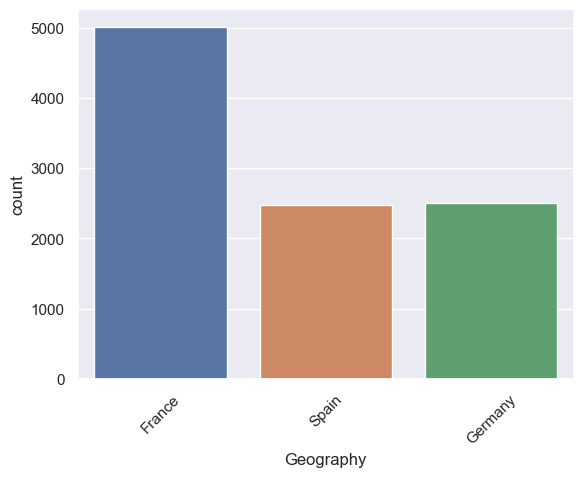

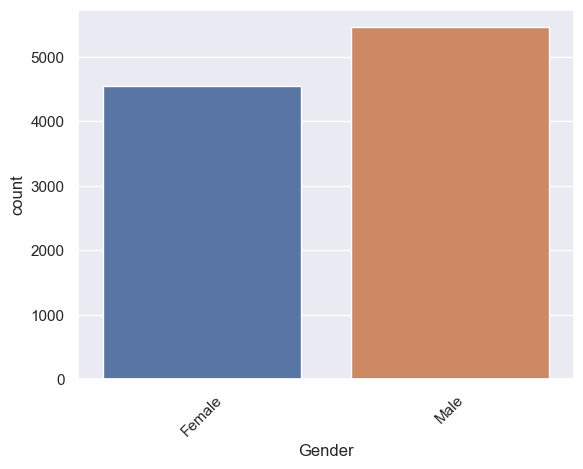

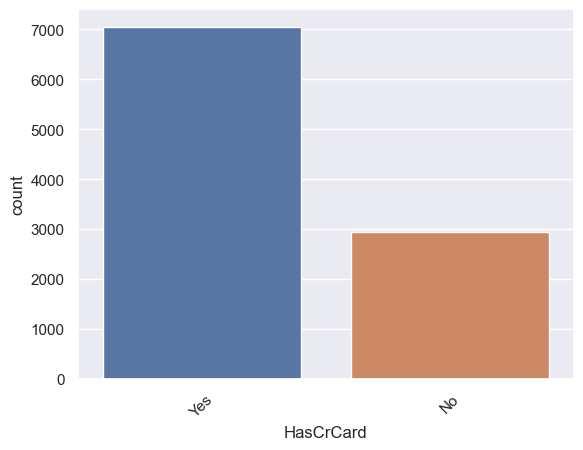

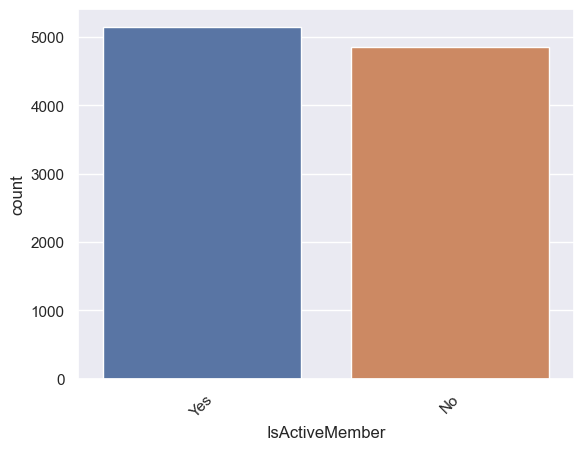

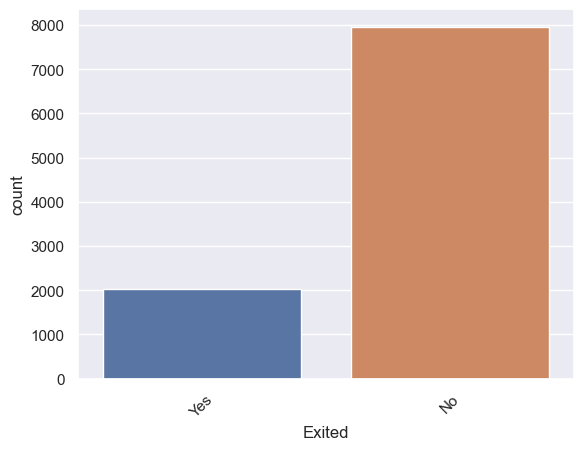

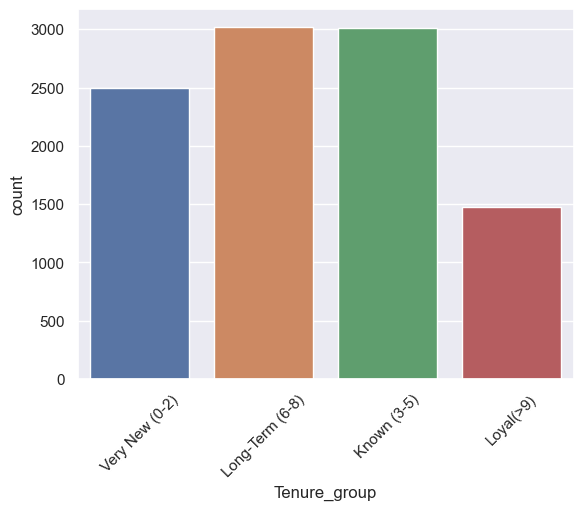

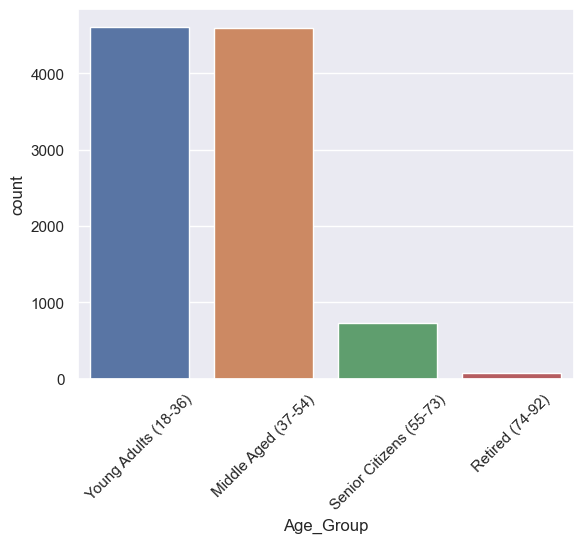

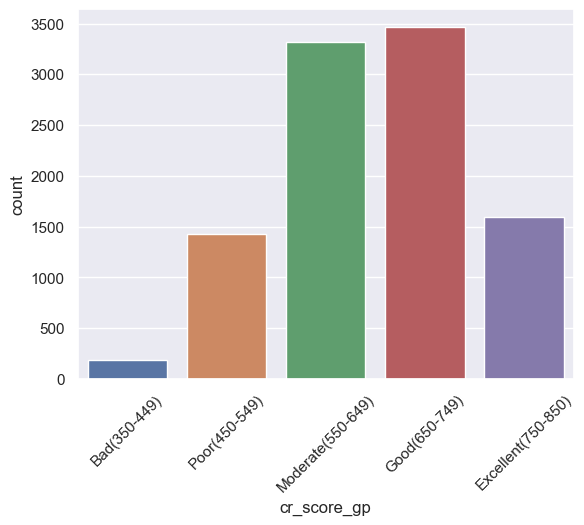

In [241]:
for i in category:
    sns.countplot(x=i, data=churn)
    plt.xticks(rotation =45)
    plt.show()

## Anlaysis
1. More number of customers are from france whereas Spain and Germany have similar count
2. Male customers are more than female
3. A lot of customers have a credict card
4. Many people have 1 or 2 products very few with 3 or 4
5. calculate the relative percentage to understand the churn 

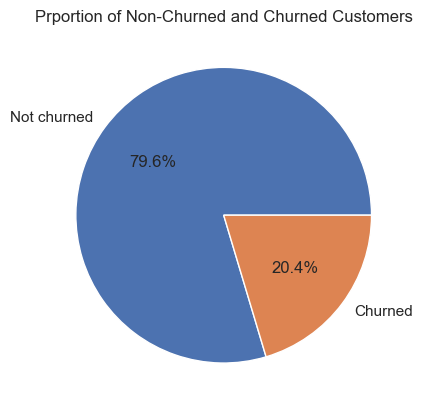

In [242]:
data = churn['Exited'].value_counts(normalize=True).to_frame(name ='prop').reset_index()
plt.pie(data=data, x='prop',labels =['Not churned','Churned'] ,autopct='%1.1f%%')
plt.title("Prportion of Non-Churned and Churned Customers")
plt.show()

### Analysis: There is a 20% of churn in customers

# 3. Outlier Detection

In [243]:


#Since there is a uniform distribution to estimated salary we will use the percentile based quantile cut off to remove outliers

lower_bound = churn['EstimatedSalary'].quantile(0.03)
#upper_bound = churn['EstimatedSalary'].quantile(0.99)

print( lower_bound)



5811.298499999999


In [244]:
churn.shape

(10000, 14)

In [245]:
churn['Exited'].value_counts(normalize=True)

Exited
No    0.80
Yes   0.20
Name: proportion, dtype: float64

# 4.Bivariant Analysis

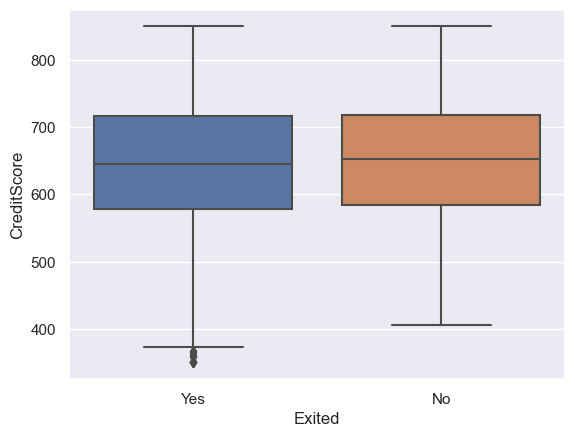

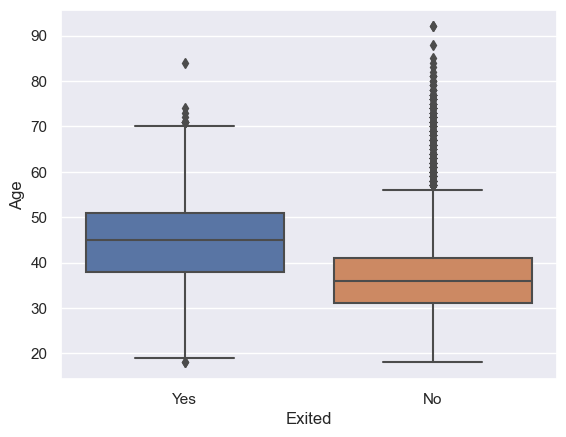

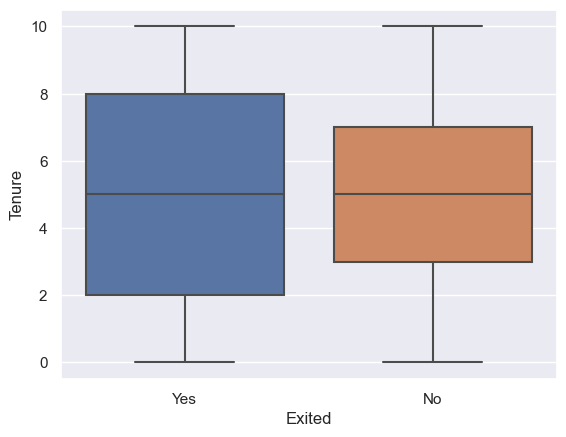

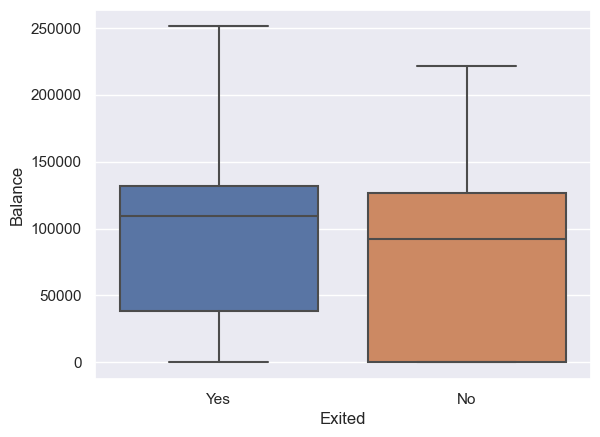

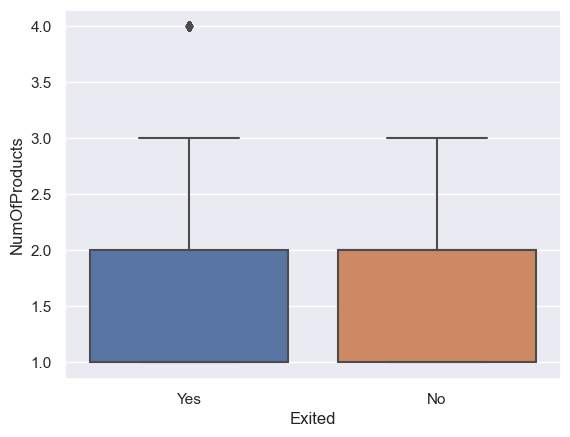

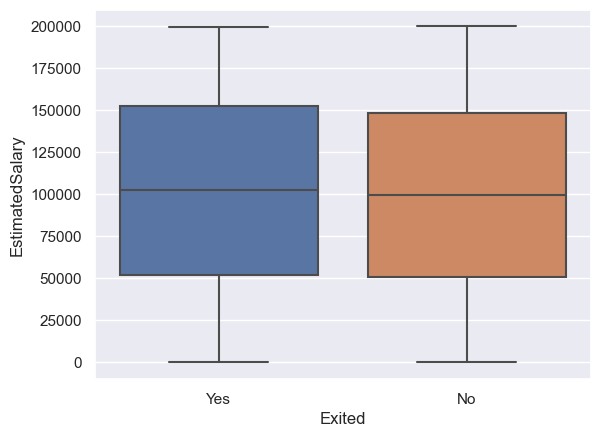

In [246]:
for i in numerical:
    sns.boxplot(data=churn, x='Exited', y=i)
    plt.show()

## Analysis:
### Churners
1. some outliers < 400 credit score
2. median age 45, outliers above 70 are churning
3. higher balance approx 110000

### Retained
1.  median 35 and outliers after the age of 55 are retained
2. median balance approx 90000

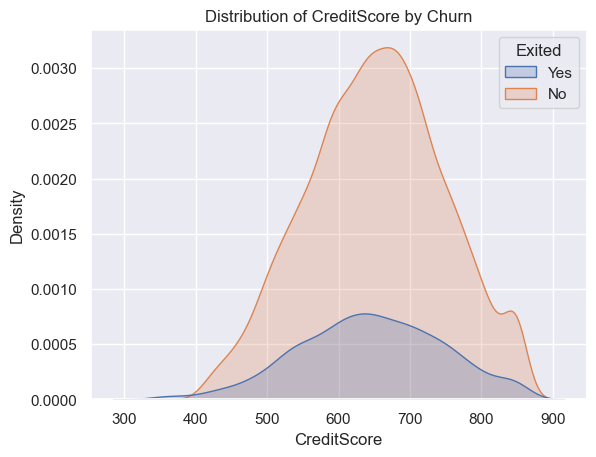

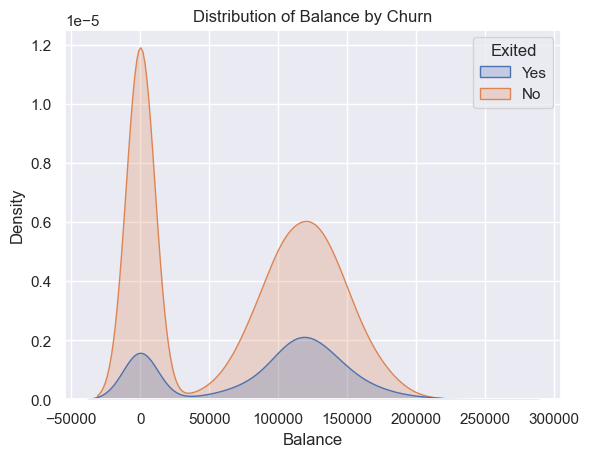

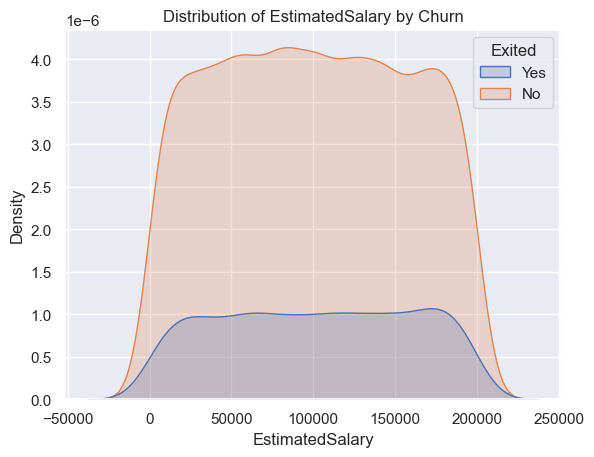

In [247]:
for col in ['CreditScore', 'Balance', 'EstimatedSalary']:
    sns.kdeplot(data=churn, x=col, hue='Exited', fill=True)
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

### No specific distinction between the churners and non-churners here so these featues on their own cannot really determine the churn factor

In [248]:
# understanding the distribution of churners
for i in category:
    data = pd.crosstab(churn[i], churn['Exited'], normalize='columns')*100
    display(data)

Exited,No,Yes
Geography,,
France,52.79,39.76
Germany,21.29,39.96
Spain,25.92,20.27


Exited,No,Yes
Gender,,
Female,42.75,55.92
Male,57.25,44.08


Exited,No,Yes
HasCrCard,,
No,29.29,30.09
Yes,70.71,69.91


Exited,No,Yes
IsActiveMember,,
No,44.54,63.92
Yes,55.46,36.08


Exited,No,Yes
Exited,,
No,100.00,0.00
Yes,0.00,100.00


Exited,No,Yes
Tenure_group,,
Known (3-5),29.95,30.68
Long-Term (6-8),30.77,27.98
Loyal(>9),14.57,15.41
Very New (0-2),24.71,25.92


Exited,No,Yes
Age_Group,,
Young Adults (18-36),52.86,19.64
Middle Aged (37-54),40.79,65.93
Senior Citizens (55-73),5.48,14.33
Retired (74-92),0.88,0.10


Exited,No,Yes
cr_score_gp,,
Bad(350-449),1.61,2.76
Poor(450-549),14.13,15.11
Moderate(550-649),32.99,33.91
Good(650-749),35.14,32.82
Excellent(750-850),16.14,15.40


## Analysis note down all the high and low churners behaviour. Ignore some analysis which might be due to data imbalance
### churners
1. 56 % churners are female
2. 64% of high churners are not active members
3. 65% of churners are middle aged (37-54)
4. 33% of churners have moderate to good Credit Score
### Retained
1. 57% of retained are male
2. 55% of retainers are active members
3. 53% of retainers are young adults (18-36)

# 5. Multivariant Analysis

1. Demographics: Age_Group, Gender, Geography

2. Financial behavior: Balance, CreditScore, NumOfProducts, HasCrCard

3. Engagement: IsActiveMember, Tenure

4. Outcome: Exited

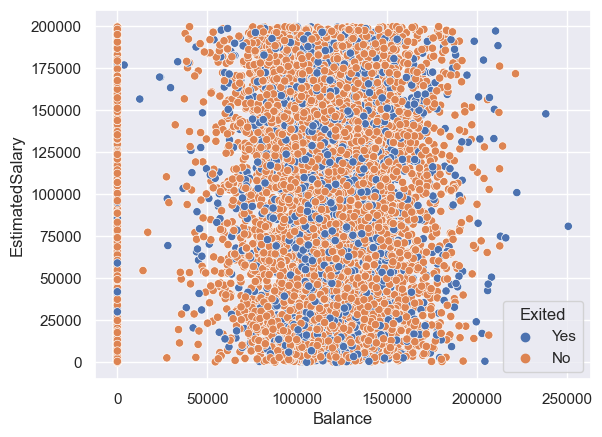

In [249]:
sns.scatterplot(data=churn, x='Balance',y='EstimatedSalary', hue='Exited')
plt.show()

### Analaysis: There is no clear clusters but it looks like customers with 0 balanced do not churn

<Axes: xlabel='Balance', ylabel='CreditScore'>

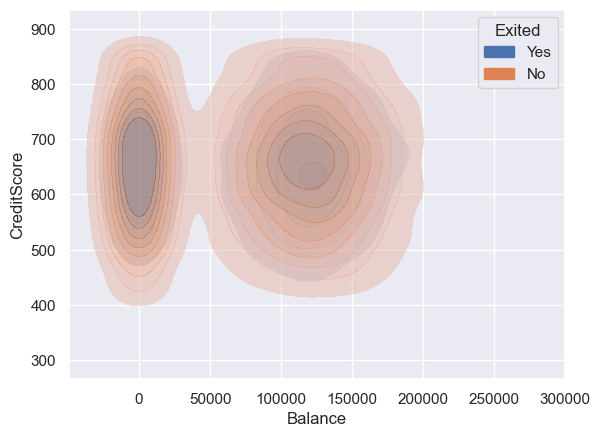

In [250]:
sns.kdeplot(
    data=churn,
    x='Balance',
    y='CreditScore',
    hue='Exited',
    fill=True,
    alpha=0.5
)


<Axes: xlabel='CreditScore'>

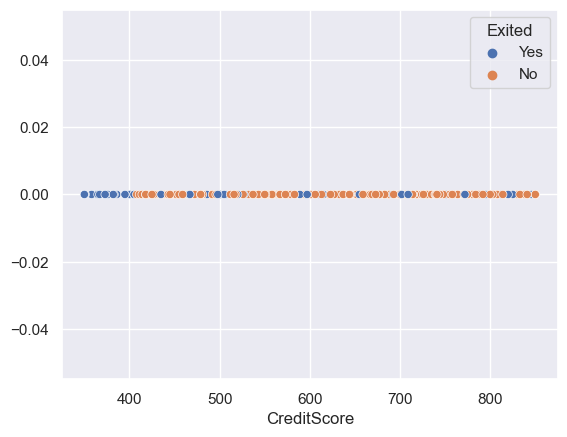

In [251]:
sns.scatterplot(data=churn, x='CreditScore', y= 0,hue='Exited')
#again we do not see any specific clusters here

In [252]:
# Statistical Analysis

In [253]:
churned=  churn[churn['Exited']=='Yes']
churned

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_group,Age_Group,cr_score_gp
0,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,Yes,Very New (0-2),Middle Aged (37-54),Moderate(550-649)
2,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,Yes,Long-Term (6-8),Middle Aged (37-54),Poor(450-549)
5,645,Spain,Male,44,8,113755.78,2,Yes,No,149756.71,Yes,Long-Term (6-8),Middle Aged (37-54),Moderate(550-649)
7,376,Germany,Female,29,4,115046.74,4,Yes,No,119346.88,Yes,Known (3-5),Young Adults (18-36),Bad(350-449)
16,653,Germany,Male,58,1,132602.88,1,Yes,No,5097.67,Yes,Very New (0-2),Senior Citizens (55-73),Good(650-749)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,498,Germany,Male,42,3,152039.70,1,Yes,Yes,53445.17,Yes,Known (3-5),Middle Aged (37-54),Poor(450-549)
9982,655,Germany,Female,46,7,137145.12,1,Yes,No,115146.40,Yes,Long-Term (6-8),Middle Aged (37-54),Good(650-749)
9991,597,France,Female,53,4,88381.21,1,Yes,No,69384.71,Yes,Known (3-5),Middle Aged (37-54),Moderate(550-649)
9997,709,France,Female,36,7,0.00,1,No,Yes,42085.58,Yes,Long-Term (6-8),Young Adults (18-36),Good(650-749)


In [254]:
gen_data = churned.groupby(['Gender']).aggregate({'Exited':'count'})
gen_data.div(gen_data.sum(axis=0), axis=1)

,Exited
Gender,
Female,0.56
Male,0.44


In [189]:
# why female churn?
churned.groupby(['Gender']).aggregate({'Exited':'count','HasCrCard':'count','CreditScore':'mean','IsActiveMember':'count','Age':'mean','EstimatedSalary':'mean'})


,Exited,HasCrCard,CreditScore,IsActiveMember,Age,EstimatedSalary
Gender,,,,,,
Female,1139,1139,646.88,1139,44.78,102948.99
Male,898,898,643.41,898,44.91,99584.29


### 56% of high churners are female but no other attribute specifically show why

In [192]:
tenure_data = churned.groupby(['Tenure_group']).aggregate({'Exited':'count','NumOfProducts':lambda x: ( x > 2).sum()})
print (tenure_data)

tenure_data['Exited'] / tenure_data['Exited'].sum()

                 Exited  NumOfProducts
Tenure_group                          
Known (3-5)         625             98
Long-Term (6-8)     570             72
Loyal(>9)           314             47
Very New (0-2)      528             63


Tenure_group
Known (3-5)       0.31
Long-Term (6-8)   0.28
Loyal(>9)         0.15
Very New (0-2)    0.26
Name: Exited, dtype: float64

### 31% high curners have 3-5 tenure ,  this range seems to be using more than 2 products

In [255]:
##Number of Products and active member
piv_counts = churned.pivot_table(index='Gender', columns ='Geography', values='Exited', aggfunc='count')
(piv_counts/piv_counts.values.sum())*100

Geography,France,Germany,Spain
Gender,,,
Female,22.58,21.99,11.34
Male,17.18,17.97,8.93


### 23% churners are from france and are female. 21% are from Germany and female

In [45]:
gen_active = churned.pivot_table(index='Gender', columns ='IsActiveMember', values='Exited', aggfunc='count')
gen_active/ gen_active.values.sum()

IsActiveMember,No,Yes
Gender,,
Female,0.36,0.20
Male,0.28,0.16


### 36% of churners are not active members are are female. 28% are not active and are male

In [46]:
tenure_age = churned.pivot_table(index='Tenure_group', columns ='Age_Group', values='Exited', aggfunc='count')
piv_tenure_age = tenure_age/tenure_age.values.sum()

In [47]:
#### 20% of high churnerd middle aged (37-54) group who have a 3-5 tenure and 18% in same age group with 6-8 tenure

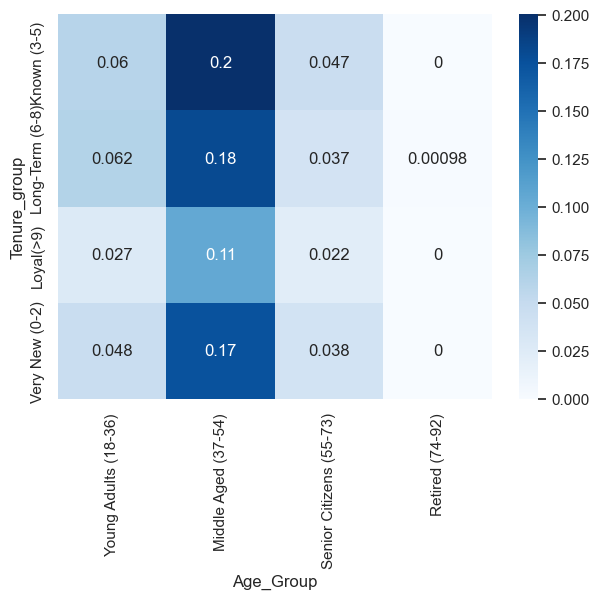

In [48]:
plt.figure(figsize =(7,5))
sns.heatmap(piv_tenure_age, annot=True, cmap='Blues')
plt.show()

In [266]:
churned.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Tenure_group', 'Age_Group', 'cr_score_gp'],
      dtype='object')

In [270]:
score_products = churned.pivot_table(index='cr_score_gp', columns ='NumOfProducts', values='Exited', aggfunc='count')
piv_score_pd= score_products/score_products.values.sum()
piv_score_pd

NumOfProducts,1,2,3,4
cr_score_gp,,,,
Bad(350-449),0.02,0.00,0.00,0.00
Poor(450-549),0.10,0.03,0.02,0.00
Moderate(550-649),0.23,0.06,0.04,0.01
Good(650-749),0.23,0.06,0.04,0.01
Excellent(750-850),0.11,0.02,0.02,0.00


In [49]:


cols = ['Balance', 'EstimatedSalary', 'CreditScore']
churned[cols].corr()
##The distribution is not normal try the spearman

,Balance,EstimatedSalary,CreditScore
Balance,1.00,-0.01,0.02
EstimatedSalary,-0.01,1.00,-0.06
CreditScore,0.02,-0.06,1.00


In [50]:
df[['Balance','EstimatedSalary','CreditScore']].corr(method='spearman')


,Balance,EstimatedSalary,CreditScore
Balance,1.00,0.01,0.01
EstimatedSalary,0.01,1.00,0.00
CreditScore,0.01,0.00,1.00


In [51]:
corr_df = churned.copy()
corr_df['Exited'] = corr_df['Exited'].map({'Yes': 1, 'No': 0})

In [52]:
corr_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_group,Age_Group
0,619,France,Female,42,2,0.00,One,Yes,Yes,101348.88,1,Very New (0-2),Middle Aged (37-54)
2,502,France,Female,42,8,159660.80,Three,Yes,No,113931.57,1,Long-Term (6-8),Middle Aged (37-54)
5,645,Spain,Male,44,8,113755.78,Two,Yes,No,149756.71,1,Long-Term (6-8),Middle Aged (37-54)
7,376,Germany,Female,29,4,115046.74,Four,Yes,No,119346.88,1,Known (3-5),Young Adults (18-36)
16,653,Germany,Male,58,1,132602.88,One,Yes,No,5097.67,1,Very New (0-2),Senior Citizens (55-73)


In [53]:
##We observe that there is no correlation between any of the numeric values with exited
#use original df
correlation = df[['Balance','EstimatedSalary','CreditScore','Exited']].corr()['Exited']
print(correlation)
#no proper correlation

Balance            0.12
EstimatedSalary    0.01
CreditScore       -0.03
Exited             1.00
Name: Exited, dtype: float64


In [54]:

#Demographic factors: Geography, Gender, Age
#Economic factors: CreditScore, Balance, EstimatedSalary
#Engagement factors: IsActiveMember, Tenure, NumOfProducts


#based on Gender, Age, creditScore, Balance, ISActive member, tenure, numofProducts
#Feature 1: Gender*IsActiveMember
#Feature 2: Age*Tenure
#Feature 3: CreditScore *NumOfPRoducts

# 7. Logistics Regression

In [55]:
df_churn = df.copy()
df_churn.drop(columns =['RowNumber','CustomerId','Surname'], inplace=True)

In [56]:
x = df_churn.drop(columns ='Exited')
y = df_churn['Exited'].to_frame()

In [57]:
x = pd.get_dummies(x, columns = ['Geography', 'Gender'], drop_first=True)

In [58]:
x.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False


In [59]:
#scale only numeric features do not  for binary values 0 and 1's columns, this can distort the logistic regression
numeric = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
x[numeric]

,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,619,42,2,0.00,101348.88
1,608,41,1,83807.86,112542.58
2,502,42,8,159660.80,113931.57
3,699,39,1,0.00,93826.63
4,850,43,2,125510.82,79084.10
...,...,...,...,...,...
9995,771,39,5,0.00,96270.64
9996,516,35,10,57369.61,101699.77
9997,709,36,7,0.00,42085.58
9998,772,42,3,75075.31,92888.52


In [60]:
mms= MinMaxScaler()
x[numeric] = mms.fit_transform(x[numeric])

In [61]:
x.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.54,0.32,0.20,0.00,1,1,1,0.51,False,False,False
1,0.52,0.31,0.10,0.33,1,0,1,0.56,False,True,False
2,0.30,0.32,0.80,0.64,3,1,0,0.57,False,False,False
3,0.70,0.28,0.10,0.00,2,0,0,0.47,False,False,False
4,1.00,0.34,0.20,0.50,1,1,1,0.40,False,True,False


In [62]:
##split the data

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [63]:
lr =LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

C:\Users\manis\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
auc = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc:.3f}")

AUC Score: 0.786


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.57      0.19      0.29       393

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



### Since we know that the dataset is imbalanced, replicating the real-world dataset. It is necessary the we catch metrics like recall and not accuracy. The recall tell us how many churners where actually predicted accuractly by the model from the total churners. a company not catching this prediction loses money hence recall> accuracy or precision.

### Since logistic regression was only able to predict 36% of churners out of total actual one, it shows this model is not right. 

In [126]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


##handle imbalance by penalising the wrong churners as non-churners by 3* times
scale_pos_weight = len(y_train[y_train['Exited']==0])/len(y_train[y_train['Exited']==1]) ## roughly 3.8 is answer

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=5)


In [127]:
# Probabilities
y_prob = model.predict(dtest)

# Convert to binary predictions using threshold 0.5, prob values >0.5 will be considered churned , you can change the threshold as you want
y_pred = (y_prob > 0.5).astype(int)
#y_pred_custom = (y_prob > 0.30).astype(int)

In [128]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1607
           1       0.45      0.81      0.58       393

    accuracy                           0.77      2000
   macro avg       0.70      0.78      0.71      2000
weighted avg       0.85      0.77      0.79      2000



In [129]:

# Example: y_test = actual churn (0 = not churned, 1 = churned)

auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc:.3f}")


AUC Score: 0.861


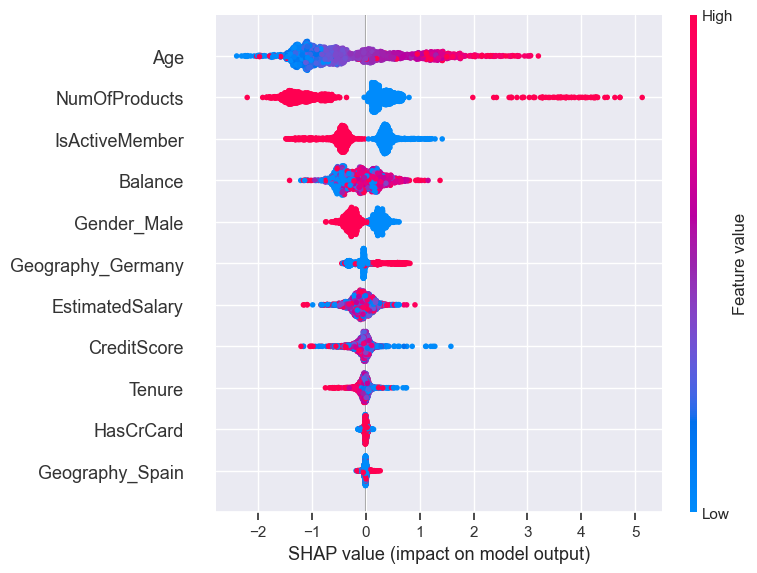

In [70]:
#8. Explainability

import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)

# Plot summary of top features
shap.summary_plot(shap_values, x_test)


In [71]:
#estimated CLV
#CLV = Annual Customer Contribution (or Annual Revenue Per User - ARPU) * Tenure
#Assuming values for each feature
#1.Assumed interest margin for balance per year is 2%
#2. Assumed each product value is 75$
#3. Assumed Credit card value is 150$
#4. Assumed Active membership is 100$
df['ARPU'] = (0.02 * df['Balance']) +  (df['NumOfProducts'] * 75) +  (df['HasCrCard'] * 150) + (df['IsActiveMember'] * 100)        

df['CLV'] = df['ARPU'] * df['Tenure']
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,ARPU,CLV
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,325.00,650.00
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1851.16,1851.16
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3568.22,28545.73
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,150.00,150.00
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2835.22,5670.43


In [84]:
avg_CLV = df['CLV'].mean() # avg CLV
print ('avg clv for customers in bank app : ', avg_CLV)
churn_rate = 0.2
total_customers  = 10000

churn_impact = avg_CLV * churn_rate * total_customers
print('Potential impact to the company ', churn_impact) # 17M $ 

avg clv for customers in bank app :  8989.99084532
Potential impact to the company  17979981.690640002


In [85]:
avg_clv_churners = df.loc[df['Exited']==1, 'CLV'].mean()
avg_clv_nonchurners = df.loc[df['Exited']==0, 'CLV'].mean()
print (' Avg CLV for churners ' , avg_clv_churners)
print (' Avg CLV for non-churners ' , avg_clv_nonchurners)

 Avg CLV for churners  10328.57036426117
 Avg CLV for non-churners  8647.571345121185


In [74]:
 df['Exited'].sum()

2037

# Possible Retention Strategies
1. Possible Financial Advisories for credit coaching for lower credit score customers
2. Push notification, engagment campaigns or personolised offers to enhance engagment and activity
3. Dedicated support through services targeting age group between 36-57
4. Localised marketing strategies for customers in Germany and France
5. Improve customer loyalty through various loyalty offers or rewarding system

In [89]:
#If the retention strategies reduce churn by 10% and 10% of the churners are retained then
current_churners = df['Exited'].sum()
reduction = 0.1
retained_churners = current_churners * reduction
savings = retained_churners * avg_clv_churners
savings
#2.1M $ can be saved if the rentention strategies are implemented 

2103929.7832000004

In [ ]:
## Here the churn 20% is reduced by 10% in relative terms. That means churn is reduce by 10% in 20% not from 20% TO 10%( this is dropping directly by 10% which is a huge reduction realistically) which is very different
##0.2 *0.1 which is 2% so overally 20% is reduced to 18%
